## Sagnac Frequency - Backscatter Correction - RV Backscatter

Explore the longterm behaviour of the RV sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2024-05-22 16:00")
# config['tend'] = UTCDateTime("2024-06-27 00:00")
config['tend'] = UTCDateTime().now()
flim1, flim2 = 447.726, 447.745

# config['tbeg'] = UTCDateTime("2024-05-31 00:00")
# config['tend'] = UTCDateTime("2024-06-01 00:00")
# flim1, flim2 = 447.726, 447.745


# reduce phase jumps
# config['tbeg'] = UTCDateTime("2024-05-23 00:00")
# config['tend'] = UTCDateTime("2024-06-06 00:00")
# flim1, flim2 = 447.726, 447.745



## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [4]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [5]:
from functions.backscatter_correction import __backscatter_correction

In [6]:
# unwrap phases as one time series
# bs['fj_ph'] = np.unwrap(bs.fj_ph)
# bs['f1_ph'] = np.unwrap(bs.f1_ph)
# bs['f2_ph'] = np.unwrap(bs.f2_ph)

# use complete unwrapped phases
bs['fj_ph'] = np.unwrap(bs.fj_phw)
bs['f1_ph'] = np.unwrap(bs.f1_phw)
bs['f2_ph'] = np.unwrap(bs.f2_phw)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)


### Find phase jumps

In [7]:
from functions.get_phase_jumps_sta_lta import get_phase_jumps_sta_lta

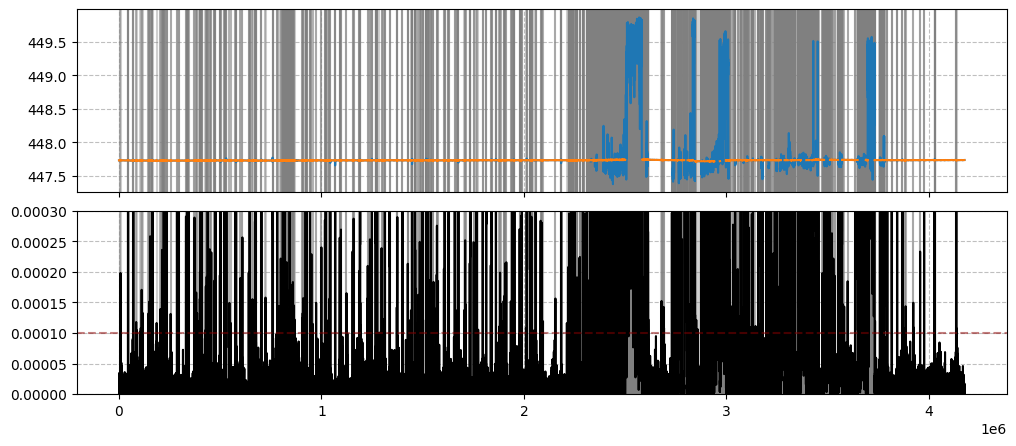

In [8]:
ratio, detect = get_phase_jumps_sta_lta(np.array(bs.fj_fs), np.array(bs.time_sec), 5, 3, amp_threshold=0.0001)

In [9]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

#### Correct phase jumps

In [10]:
def __reduce_phase_jumps(data, detect):

    data = np.array(data)

    for _i in range(len(data)):

        if detect[_i] == 1:
            left = np.nanmean(data[_i-8:_i-3])
            right = np.nanmean(data[_i+3:_i+8])

            diff = left - right

            data[_i-3:_i] = left

            data[_i:] += diff

    return data

### Cut corrupt data periods

In [11]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [12]:
def __time_spans_to_nan(bs, time_spans):

    for t1, t2 in time_spans:
        bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
        bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


time_spans = [("2024-06-20T12:00", "2024-06-21T12:00"),
              ("2024-06-24T12:00", "2024-06-26T06:00")
             ]

__time_spans_to_nan(bs, time_spans)

In [13]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [14]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [15]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

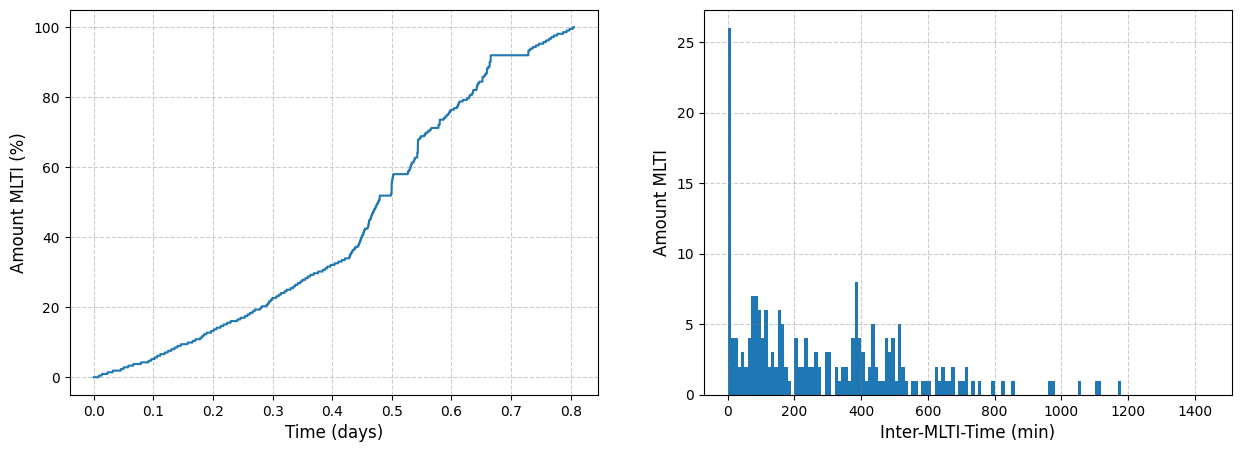

In [16]:
from functions.get_mlti_statistics import __get_mlti_statistics

arr_mlti, mlti_cumsum, mlti_cumsum_perc, mlti_inter_sec = __get_mlti_statistics(mlti_t1, bs.time1, plot=True, ylog=False)

### Apply special filter sections

In [17]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [18]:
from functions.smoothing import __smooth

n_minutes = 60

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [19]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [20]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_3101751/1830721788.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


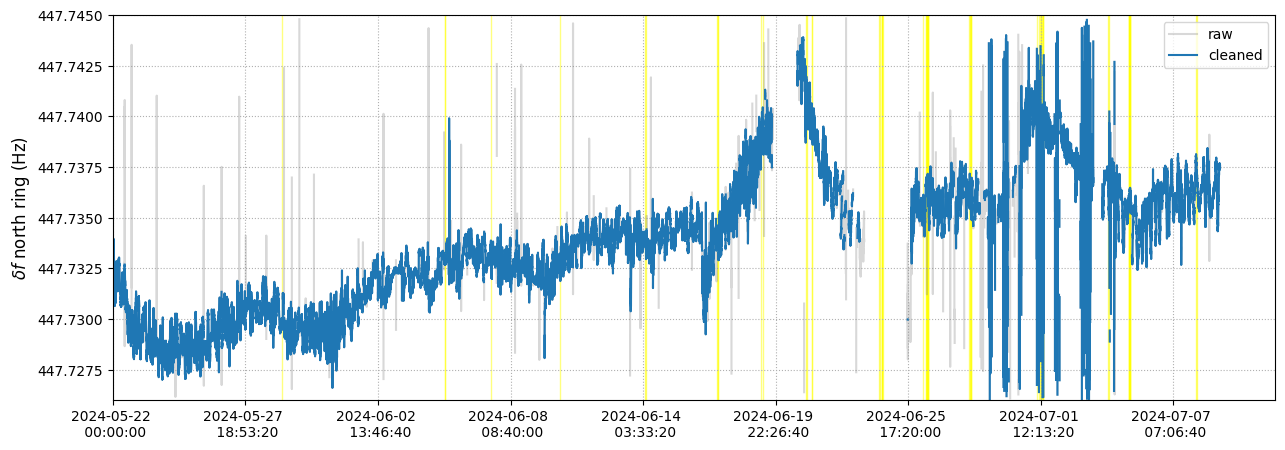

In [21]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring'}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


In [22]:
bs['fj_fs_dejump'] = __reduce_phase_jumps(bs.fj_fs_inter, detect)
bs['fj_bs_dejump'] = __reduce_phase_jumps(bs.fj_bs_inter, detect)

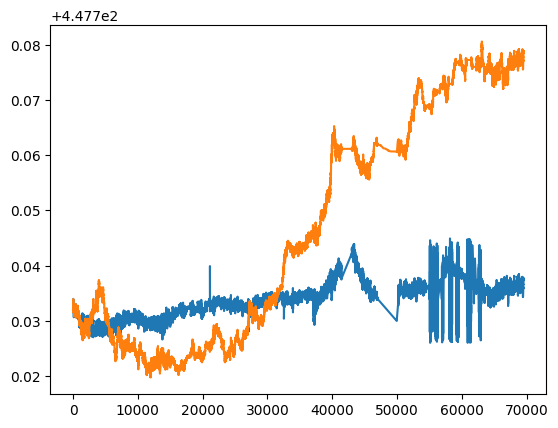

In [23]:
plt.plot(bs.fj_fs_inter)
plt.plot(bs.fj_fs_dejump)

In [24]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

bs['fj_bs_smooth_inter'] = __interpolate_nan(np.array(bs.fj_bs_smooth))

dat1 = detrend(bs.fj_fs_inter, type="linear")
dat2 = detrend(bs.fj_bs_inter, type="linear")
dat3 = detrend(bs.fj_bs_smooth_inter, type="linear")

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

psd1, f1, pha1 = __get_fft(dat1, 60, window="cosine")
psd2, f2, pha2 = __get_fft(dat2, 60, window="cosine")
psd3, f3, pha3 = __get_fft(dat3, 60, window="cosine")
# psd1, f1, pha1 = __get_fft(dat1, 60)
# psd2, f2, pha2 = __get_fft(dat2, 60)
# psd3, f3, pha3 = __get_fft(dat3, 60)

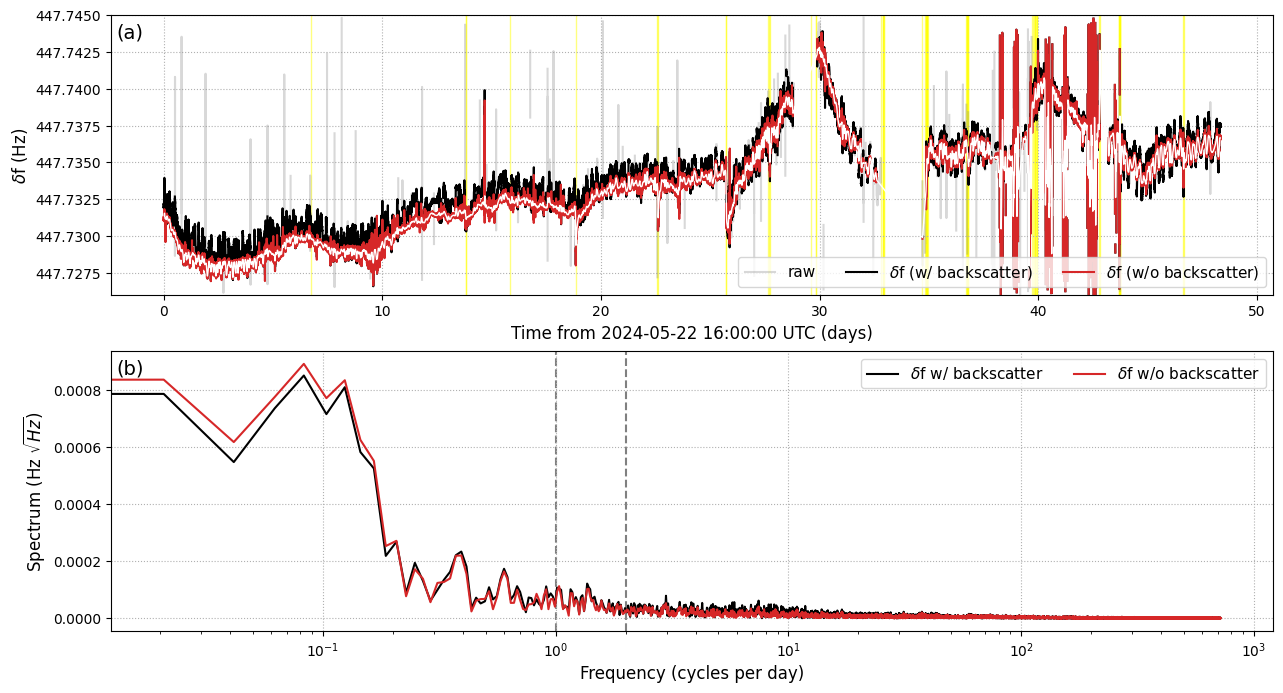

In [25]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1*86400, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2*86400, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")
    # ax[1].semilogx(f3, psd3, color="tab:grey", label=f"$\delta$f w/o backscatter (smooth)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=4, fontsize=font-1, ncol=3)
    ax[1].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (cycles per day)", fontsize=font)

    ax[1].axvline(1/(12*3600)*86400, ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600)*86400, ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


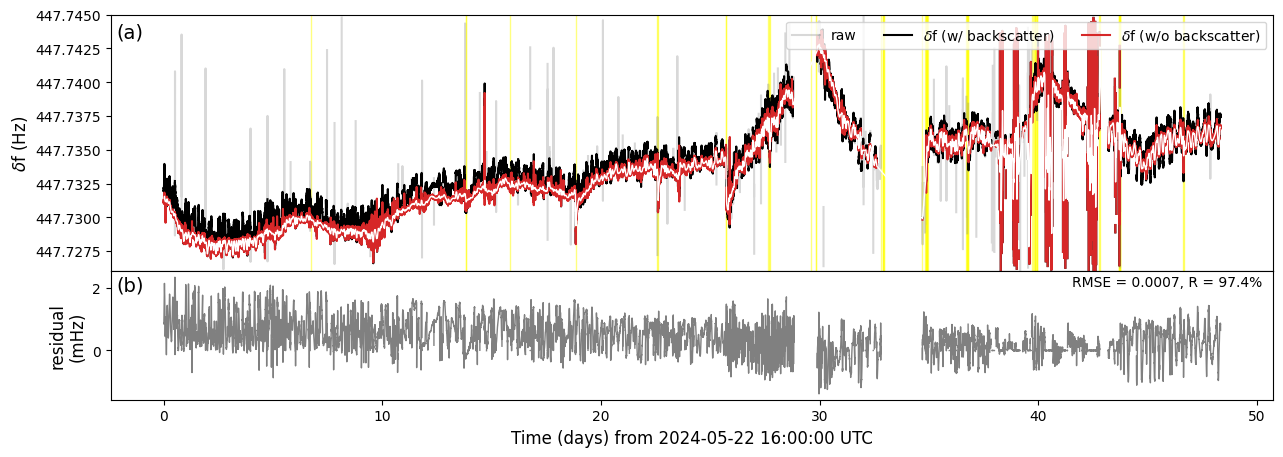

In [26]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


In [27]:
# from andbro__store_as_pickle import __store_as_pickle

# __store_as_pickle(fig, "/home/andbro/notebooks/RomyMonitor/images/fig0.pkl")

## Plot with zoom-in

In [45]:
# %matplotlib tk

17280 19872


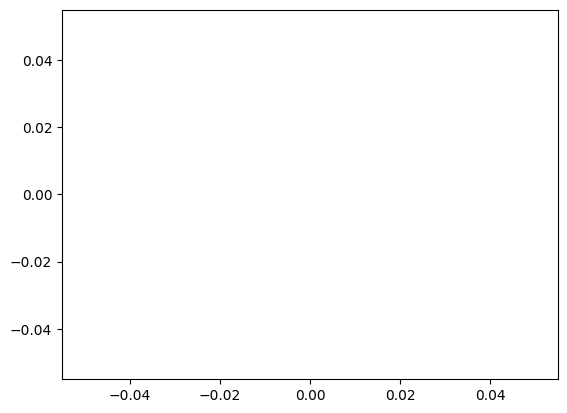

In [46]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 2, 5

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=1)

    ax1 = fig.add_subplot(gs1[0:2, :])
    ax2 = fig.add_subplot(gs1[2, :])
    ax3 = fig.add_subplot(gs2[3:5, :1])
    ax4 = fig.add_subplot(gs2[3:5, 1:])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    t31, t32 = 2.0, 2.7 # days
    t31, t32 = 12.0, 13.8 # days
    # t31, t32 = 8.0, 9.0 # days
    n31, n32 = int(t31*1440), int(t32*1440)
    print(n31, n32)
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs[n31:n32], color="tab:grey", alpha=0.3, label="raw")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs_nan[n31:n32], color="black", label=f"$\delta$f (w/ backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_nan[n31:n32], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_smooth[n31:n32], color="w", lw=1)
    ax3.set_xlim(t31, t32)

    t41 ,t42 = 18.5, 19.3 # days
    n41, n42 = int(t41*1440), int(t42*1440)
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs[n41:n42], color="tab:grey", alpha=0.3, label="raw")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs_nan[n41:n42], color="black", label=f"$\delta$f (w/ backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_nan[n41:n42], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_smooth[n41:n42], color="w", lw=1)
    ax4.set_xlim(t41, t42)


    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n31]*tscale, bs.time_sec[n32]*tscale,
                      color="purple", alpha=0.1
                     )
    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n41]*tscale, bs.time_sec[n42]*tscale,
                      color="purple", alpha=0.1
                     )

    ax1.set_ylim(flim1, flim2)
    ax3.set_ylim(447.730, 447.735)
    ax4.set_ylim(447.728, 447.735)

    for ax in [ax1, ax3, ax4]:
        ax.ticklabel_format(useOffset=False)
        ax.set_ylabel(f"$\delta$f (Hz)", fontsize=font)

    ax1.legend(loc=4, ncol=3)

    ax2.set_ylabel(f"Residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")


    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax3.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax4.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


## Make Stream

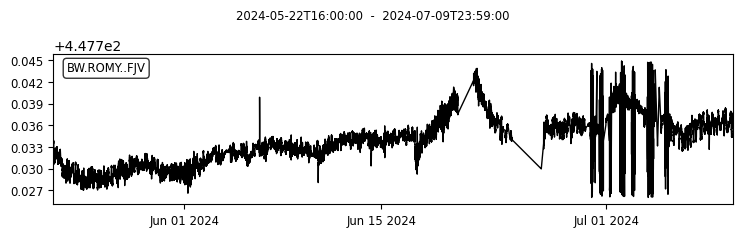

In [47]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_fs_inter)

rx = Trace()
rx.data = dff
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

## Temperature driven deformation

In [48]:
UTCDateTime("2024-05-22 16:00")+12.0298*86400, UTCDateTime("2024-05-22 16:42:54")+12.613*86400

(2024-06-03T16:42:54.720000Z, 2024-06-04T07:25:37.200000Z)

In [110]:
# example 1
# t1, t2 = UTCDateTime("2024-06-03 16:42:54"), UTCDateTime("2024-06-04 06:45:00")
# flower, fhigher = -1, 2

# example 2
t1, t2 = UTCDateTime("2024-07-02 07:25:00"), UTCDateTime("2024-07-02 18:30:00")
flower, fhigher = -3, 1

dt = 3600

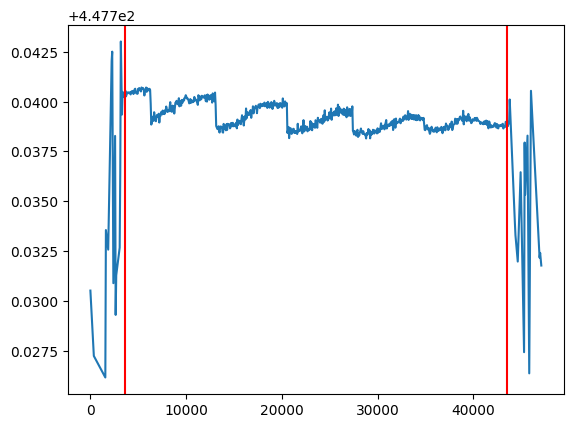

In [111]:
_rx0 = rx.copy()
rx0 = _rx0.trim(t1-dt, t2+dt)[0].data
tt0 = _rx0.trim(t1-dt, t2+dt)[0].times()
plt.plot(tt0, rx0)
plt.axvline(t1-_rx0[0].stats.starttime, color="r")
plt.axvline(t2-_rx0[0].stats.starttime, color="r")

In [112]:
_ps1 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", t1-dt, t2+dt)
_ps7 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", t1-dt, t2+dt)
_ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", t1-dt, t2+dt)

In [113]:
for _ps in [_ps1, _ps7, _ps9]:
    _ps.detrend("demean")
    _ps.decimate(10, no_filter=False)
    _ps.decimate(6, no_filter=False)


1 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 1.0 Hz, 47101 samples

1 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 0.1 Hz, 4711 samples

1 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 60.0 s, 786 samples

1 Trace(s) in Stream:
BW.PROMY.07.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 1.0 Hz, 47101 samples

1 Trace(s) in Stream:
BW.PROMY.07.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 0.1 Hz, 4711 samples

1 Trace(s) in Stream:
BW.PROMY.07.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 60.0 s, 786 samples

1 Trace(s) in Stream:
BW.PROMY.09.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 1.0 Hz, 47101 samples

1 Trace(s) in Stream:
BW.PROMY.09.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 0.1 Hz, 4711 samples

1 Trace(s) in Stream:
BW.PROMY.09.LKI | 2024-07-02T06:25:00.000000Z - 2024-07-02T19:30:00.000000Z | 60.0 s, 786 samples

In [114]:
def __get_diff(arr):
    return round(arr[~np.isnan(arr)][-1] - arr[~np.isnan(arr)][0], 5)

In [115]:
# selected interval and surrounding
_rx0 = rx.copy()
rx0 = _rx0.trim(t1-dt, t2+dt)[0].data
trx0 = _rx0[0].times(reftime=t1)

_ps01 = _ps1.copy()
ps01 = _ps01[0].data
tps01 = _ps01[0].times(reftime=t1)

_ps07 = _ps7.copy()
ps07 = _ps07[0].data
tps07 = _ps07[0].times(reftime=t1)

_ps09 = _ps9.copy()
ps09 = _ps09[0].data
tps09 = _ps09[0].times(reftime=t1)

# selected interval
_rx1 = rx.copy()
rx1 = _rx1.trim(t1, t2)[0].data
trx1 = _rx1[0].times(reftime=t1)


_ps11 = _ps1.copy()
ps11 = _ps11.trim(t1, t2)[0].data
tps11 = _ps11[0].times(reftime=t1)

_ps17 = _ps7.copy()
ps17 = _ps17.trim(t1, t2)[0].data
tps17 = _ps17[0].times(reftime=t1)

_ps19 = _ps9.copy()
ps19 = _ps19.trim(t1, t2)[0].data
tps19 = _ps19[0].times(reftime=t1)

rn = 100
_reduce = np.nanmean(ps11[:rn])
ps11 -= _reduce
ps01 -= _reduce
_reduce = np.nanmean(ps17[:rn])
ps17 -= _reduce
ps07 -= _reduce
_reduce = np.nanmean(ps19[:rn])
ps19 -= _reduce
ps09 -= _reduce

rn = 10
_reduce = np.nanmean(rx1[:rn])
rx1 -= _reduce
rx0 -= _reduce

ps11_smooth = __smooth(ps01, 120)
ps17_smooth = __smooth(ps07, 120)
ps19_smooth = __smooth(ps09, 120)

rx1_smooth = __smooth(rx1, 180)
rx11_smooth = __smooth(rx0, 180)

ps_all = (ps01+ps07+ps09)
ps_all_smooth = __smooth(ps_all, 120)

print("ps11: ", __get_diff(ps11_smooth))
print("ps17: ", __get_diff(ps17_smooth))
print("ps19: ", __get_diff(ps19_smooth))

ps11:  0.00266
ps17:  -0.053
ps19:  -0.02139


In [116]:
_ps_diff = np.nanmean(ps11[-10:]) - np.nanmean(ps11[:10])
print(_ps_diff)

_rx_diff = np.nanmean(rx1[-10:]) - np.nanmean(rx1[:10])
print(_rx_diff)

0.0007558913890423517
-0.001604351710773244


In [117]:
alpha = 15e-6 # m/m/°C

strain = 633e-9 / 36

strain / alpha

0.0011722222222222223

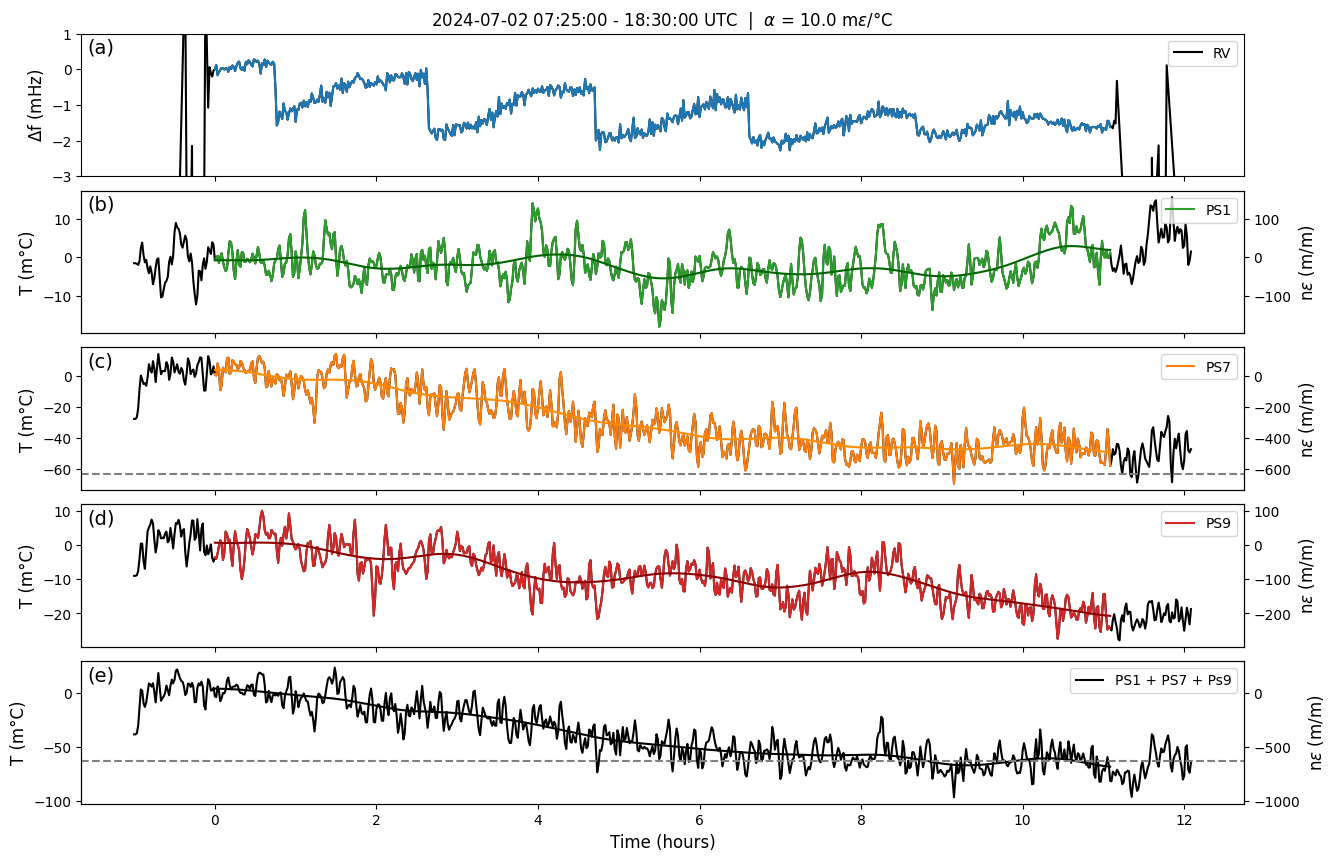

In [130]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/3600, "hours"
    Tscale, Tunit = 1e3, "m°C"
    fscale, funit = 1e3, "mHz"

    eunit = "m/m"
    alpha = 10e-6 * 1e9

    ps11_diff = round(__get_diff(ps11_smooth*alpha), 1)
    ps17_diff = round(__get_diff(ps17_smooth*alpha), 1)
    ps19_diff = round(__get_diff(ps19_smooth*alpha), 1)


    ax[0].plot(trx0*tscale, rx0*fscale, color="black", label="RV")
    ax[0].plot(trx1*tscale, rx1*fscale, color="tab:blue")
    # ax[0].plot(trx1*tscale, rx1_smooth*fscale, color="darkblue")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(tps01*tscale, ps01*Tscale, color="black", zorder=2)
    ax[1].plot(tps11*tscale, ps11*Tscale, color="tab:green", label="PS1", zorder=2)
    ax[1].plot(tps01*tscale, ps11_smooth*Tscale, color="darkgreen", zorder=2)

    ax111 = ax[1].twinx()
    ax111.plot(tps01*tscale, ps01*alpha, color="tab:purple", zorder=0, alpha=0, label=f"PS1 ($\Delta\epsilon$ = {ps11_diff}nm)")

    ax[2].plot(tps07*tscale, ps07*Tscale, color="black", zorder=2)
    ax[2].plot(tps17*tscale, ps17*Tscale, color="tab:orange", label="PS7", zorder=2)
    ax[2].plot(tps07*tscale, ps17_smooth*Tscale, color="darkorange", zorder=2)

    ax222 = ax[2].twinx()
    ax222.plot(tps07*tscale, ps07*alpha, color="tab:purple", zorder=0, alpha=0, label=f"PS7 ($\Delta\epsilon$ = {ps17_diff}nm)")

    ax[3].plot(tps09*tscale, ps09*Tscale, color="black", zorder=2)
    ax[3].plot(tps19*tscale, ps19*Tscale, color="tab:red", label="PS9", zorder=2)
    ax[3].plot(tps09*tscale, ps19_smooth*Tscale, color="darkred", zorder=2)

    ax333 = ax[3].twinx()
    ax333.plot(tps09*tscale, ps09*alpha, color="tab:purple", zorder=0, alpha=0, label=f"PS9 ($\Delta\epsilon$ = {ps19_diff}nm)")

    ax[4].plot(tps09*tscale, ps_all*Tscale, color="black", label="PS1 + PS7 + Ps9", zorder=2)
    # ax[4].plot(tps09*tscale, ps_all*Tscale, color="black", zorder=2)

    ax444 = ax[4].twinx()
    ax444.plot(tps09*tscale, ps_all*alpha, color="tab:purple", zorder=0, alpha=0, label=f"PS9 ($\Delta\epsilon$ = {ps19_diff}nm)")
    ax444.plot(tps09*tscale, ps_all_smooth*alpha, color="black", zorder=0, label=f"PS9 ($\Delta\epsilon$ = {ps19_diff}nm)")


    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[2].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[3].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[4].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[4].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax111.set_ylabel(f"n$\epsilon$ ({eunit})", fontsize=font)
    ax222.set_ylabel(f"n$\epsilon$ ({eunit})", fontsize=font)
    ax333.set_ylabel(f"n$\epsilon$ ({eunit})", fontsize=font)
    ax444.set_ylabel(f"n$\epsilon$ ({eunit})", fontsize=font)

    ax[0].set_ylim(flower, fhigher)
    # ax[1].set_ylim(-20, 20)

    # ax111.set_yticks(np.linspace(ax111.get_yticks()[0], ax111.get_yticks()[-1], len(ax[1].get_yticks())))
    # ax111.set_yticks(ax[1].get_yticks()*alpha)
    for f in range(1, 4):
        for a, e in zip([ax111, ax222, ax333, ax444], [ps01, ps07, ps09, ps_all]):
            if max(e*alpha) > f*633:
                a.axhline(f*633, color="grey", ls="--", label="633 nm")
            if min(e*alpha) < -f*633:
                a.axhline(-f*633, color="grey", ls="--", label="633 nm")

    for _n in range(Nrow):
        # ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    t_str = f"{t1.date} {str(t1.time).split('.')[0]} - {str(t2.time).split('.')[0]} UTC"
    aa, ee = r"$\alpha$", r"$\epsilon$"
    ax[0].set_title(f"{t_str}  |  {aa} = {alpha*1e-3} m{ee}/°C")

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_temperature_trend_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


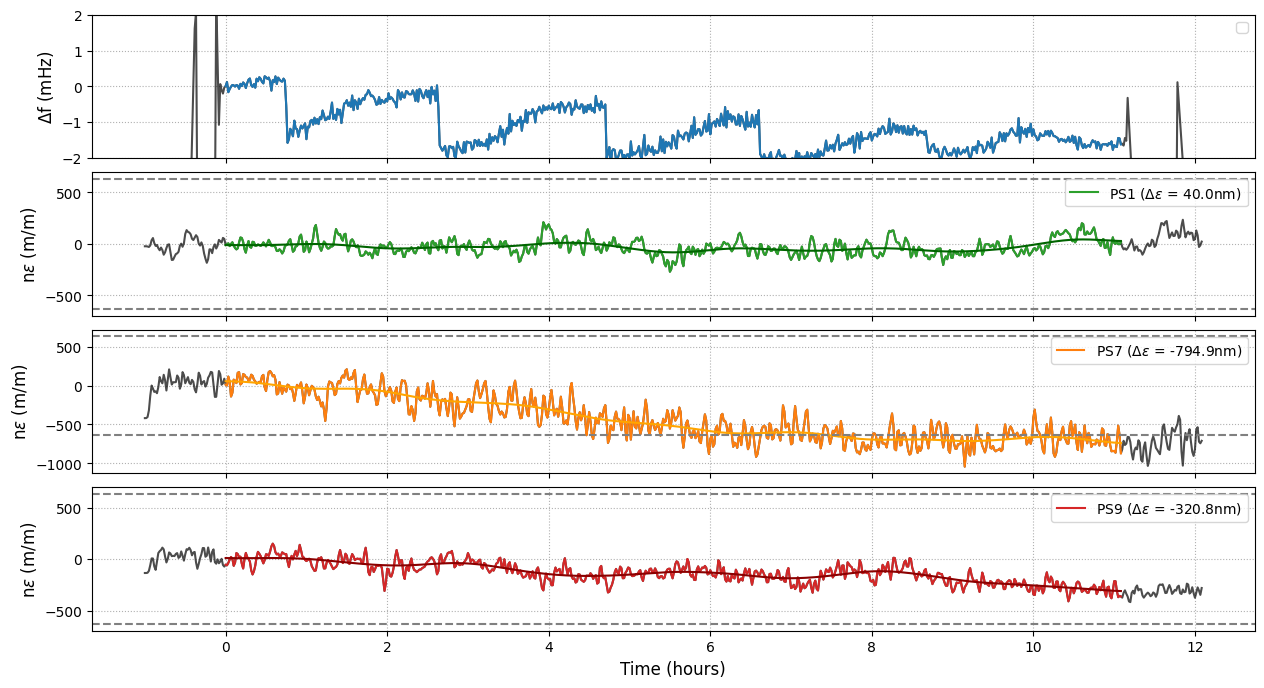

In [123]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/3600, "hours"
    Tscale, Tunit = 1, "m/m"
    fscale, funit = 1e3, "mHz"

    alpha = 15e-6 * 1e9

    ps11_diff = round(__get_diff(ps11_smooth*alpha), 1)
    ps17_diff = round(__get_diff(ps17_smooth*alpha), 1)
    ps19_diff = round(__get_diff(ps19_smooth*alpha), 1)

    ax[0].plot(trx0*tscale, rx0*fscale, color="black", alpha=0.7)
    ax[0].plot(trx1*tscale, rx1*fscale, color="tab:blue")
    # ax[0].plot(trx1*tscale, rx1_smooth*fscale, color="darkblue")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(tps01*tscale, ps01*alpha, color="black", alpha=0.7)
    ax[1].plot(tps11*tscale, ps11*alpha, color="tab:green", label=f"PS1 ($\Delta\epsilon$ = {ps11_diff}nm)")
    ax[1].plot(tps01*tscale, ps11_smooth*alpha, color="darkgreen")

    ax[2].plot(tps07*tscale, ps07*alpha, color="black", alpha=0.7)
    ax[2].plot(tps17*tscale, ps17*alpha, color="tab:orange", label=f"PS7 ($\Delta\epsilon$ = {ps17_diff}nm)")
    ax[2].plot(tps07*tscale, ps17_smooth*alpha, color="orange")

    ax[3].plot(tps09*tscale, ps09*alpha, color="black", alpha=0.7)
    ax[3].plot(tps19*tscale, ps19*alpha, color="tab:red", label=f"PS9 ($\Delta\epsilon$ = {ps19_diff}nm)")
    ax[3].plot(tps09*tscale, ps19_smooth*alpha, color="darkred")

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[2].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[3].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[3].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax[0].set_ylim(-2, 2)

    for _k in range(1, 4):
        ax[_k].axhline(633, color="grey", ls="--")
        ax[_k].axhline(-633, color="grey", ls="--")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_strain_trend_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


In [42]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_bs_inter)

dff_tilt = __sagnac_to_tilt(dff, config['ring'])

rx = Trace()
rx.data = dff_tilt
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [43]:
fmin, fmax = 1/(24*3600), 1/(1*3600)


rxx = rx.copy()

rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=False)
rxx = rxx.detrend("linear")

rxx = rxx.taper(0.05)

# rxx = rxx.filter("lowpass", freq=fmax, corners=2, zerophase=True)

rxx = rxx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# rxx = rxx.resample(10*fmax, no_filter=True)
rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=True)

rxx

rxx.plot();